In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
import scipy.integrate as integrate
from scipy.special import gamma, factorial, gammaincinv, gammainc

import os
homedir=os.getenv('HOME')

-----

In [2]:
#display psf, GALFIT output parameters

psf = fits.getdata(homedir+'/psf_test/NGC5719-custom-psf-W3.fits.fz',header=True)
psf_im = psf[0]
psf_header = psf[1]

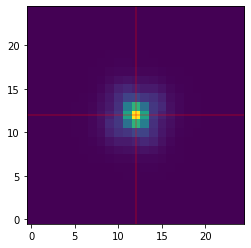

In [3]:
plt.imshow(psf_im[150:175,150:175],origin='lower')
plt.axhline(12,color='red',alpha=0.3)
plt.axvline(12,color='red',alpha=0.3)
plt.show()

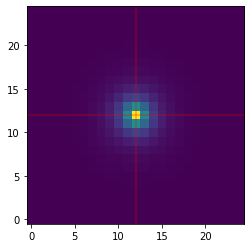

In [4]:
#model
psf_output=fits.open(homedir+'/psf_test/psf-galfit-out.fits')
plt.imshow(psf_output[2].data[150:175,150:175],origin='lower')
plt.axhline(12,color='red',alpha=0.3)
plt.axvline(12,color='red',alpha=0.3)
plt.show()

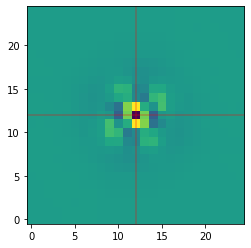

In [5]:
plt.imshow(psf_output[3].data[150:175,150:175],origin='lower')
plt.axhline(12,color='red',alpha=0.3)
plt.axvline(12,color='red',alpha=0.3)
plt.show()

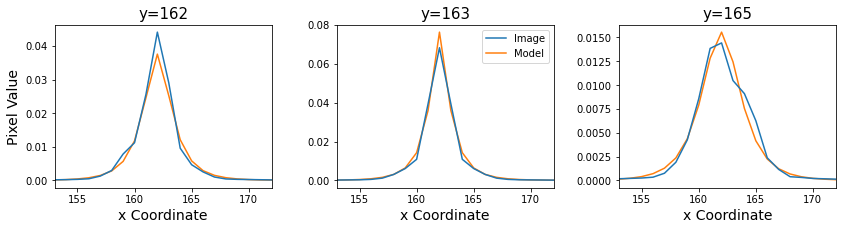

In [6]:
#compare flux profiles (i.e., pixel values) of psf image and model at y=162,163,165
y_indices=[161,162,164]

fig = plt.figure(figsize=(14,3))
plt.subplots_adjust(hspace=.5,wspace=0.3)
for panel in range(3):
    y_index = y_indices[panel]
    ax = fig.add_subplot(1,3,panel+1)
    plt.plot(np.arange(0,len(psf_im),1),psf_im[y_index],zorder=1,label='Image')
    plt.plot(np.arange(0,len(psf_output[2].data),1),psf_output[2].data[y_index],zorder=0,label='Model')
    plt.xlim(153,172)
    plt.title(f'y={y_index+1}',fontsize=15)
    plt.xlabel('x Coordinate',fontsize=14)
    if panel==0:
        plt.ylabel('Pixel Value',fontsize=14)
    if panel == 1:
        plt.legend()

In [7]:
psf_output[2].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  324 / Length of data axis 1                          
NAXIS2  =                  324 / Length of data axis 2                          
OBJECT  = 'model   '           / Component type                                 
COMMENT ========== GALFIT Input Parameters ==========                           
INITFILE= 'VFID6056-NGC4289-galfit.input.1Comp' / GALFIT input file             
DATAIN  = '/Users/k215c316/psf_test/NGC5719-custom-psf-W3.fits.fz' / Input data 
SIGMA   = 'none    '           / Input sigma image                              
PSF     = '#PSF image'         / Convolution PSF and kernel                     
CONSTRNT= 'none    '           / Parameter constraint file                      
MASK    = 'none    '        

In [70]:
#parameters from galfit header information
n=1.3961   #+/-0.0032
R_e=2.2325 #+/-0.0036
xc_model=163   #header information
yc_model=163   #header information

-----

In [9]:
npoints = 4000

In [71]:
#aperture photometry on image and model
enc_flux_im = np.zeros(npoints)
enc_flux_model = np.zeros(npoints)
radii=np.linspace(0.01,200,npoints)
xc_im=int(psf_im.shape[0]/2)
yc_im=int(psf_im.shape[1]/2)

for i in range(npoints):
    aperture_im=CircularAperture((xc_im,yc_im),r=radii[i])
    aperture_model=CircularAperture((xc_model,yc_model),r=radii[i])
    table_im = aperture_photometry(psf_output[1].data,aperture_im)
    table_model = aperture_photometry(psf_output[2].data,aperture_model)
    enc_flux_im[i] = table_im['aperture_sum']
    enc_flux_model[i] = table_model['aperture_sum']

----

In [11]:
#Sersic profile curves

The 2D surface brightness distribution of a Sersic profile is 
#### $I(r) = I_e \exp{[-b_n((\frac{r}{r_e})^{1/n}-1)]}$,
where \
$I_e = I(r_e)$ \
$b_n$ is defined such that $r_e$ contains 1/2 the total flux of the profile \
b_n = gammaincinv(2.*n, 0.5) \
Integrated, the function I(r) is
#### $I(r) = \frac{2\pi n r_e^2}{b_n^{2n}}I_e e^{b_n}\gamma(2n, b_n (\frac{r}{r_e})^{1/n}$)


In [72]:
def b(n):
    # Normalisation constant
    return gammaincinv(2*n, 0.5)

In [73]:
def sersic_lum(Ie, re, n):
    # total luminosity (integrated to infinity)
    bn = b(n)
    g2n = gamma(2*n)
    return Ie * re**2 * 2*np.pi*n * np.exp(bn)/(bn**(2*n)) * g2n

def sersic_enc_lum(r, Ie, re, n):
    # luminosity enclosed within a radius r
    x = b(n) * (r/re)**(1.0/n)
    return sersic_lum(Ie, re, n) * gammainc(2*n, x)

In [74]:
#find max flux in order to normalize curve. set I_e=1 for test.
max_flux_galfit = sersic_lum(1,R_e,n)
max_flux_gauss = sersic_lum(1,R_e,0.5)

In [75]:
#calculate normalized enclosed flux values for 0<R<300 px
sersic_flux=np.zeros(npoints)
gauss_flux=np.zeros(npoints)
for i in range(npoints):
    sersic_flux[i] = sersic_enc_lum(radii[i],1,R_e,n)/max_flux_galfit   #for GALFIT profile
    gauss_flux[i] = sersic_enc_lum(radii[i],1,R_e,0.5)/max_flux_gauss   #for gaussian profile

-----

In [76]:
#plot and compare...

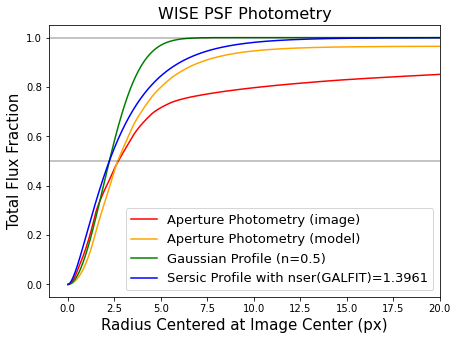

In [86]:
plt.figure(figsize=(7,5))

plt.plot(radii,enc_flux_im/np.sum(psf_output[1].data),color='red',label='Aperture Photometry (image)')
plt.plot(radii,enc_flux_model/np.sum(psf_output[2].data),color='orange',label='Aperture Photometry (model)')
plt.plot(radii,gauss_flux,color='green',label='Gaussian Profile (n=0.5)')
plt.plot(radii,sersic_flux,color='blue',label=f'Sersic Profile with nser(GALFIT)={n}')

plt.axhline(1,color='black',alpha=0.3)
plt.axhline(0.5,color='black',alpha=0.3)

plt.xlabel('Radius Centered at Image Center (px)',fontsize=15)
plt.ylabel('Total Flux Fraction',fontsize=15)
plt.title('WISE PSF Photometry',fontsize=16)
plt.legend(fontsize=13)
plt.xlim(-1,20)
plt.show()

In [84]:
#The model curves *at least* ought to be superimposed, no? And yet, I cannot seem to identify why
#this is not the case.

-----

In [18]:
#find parameters of sersic profile that appear to 'best fit' the red line, then run galfit on psf image with those
#Re and nser fixed. I guess.

In [62]:
Ie=1
n=20
R_e=1.55
test=np.zeros(npoints)
for i in range(npoints):
    test[i] = sersic_enc_lum(radii[i],Ie,R_e,n)/sersic_enc_lum(sersic_lum(Ie,R_e,n),Ie,R_e,n)

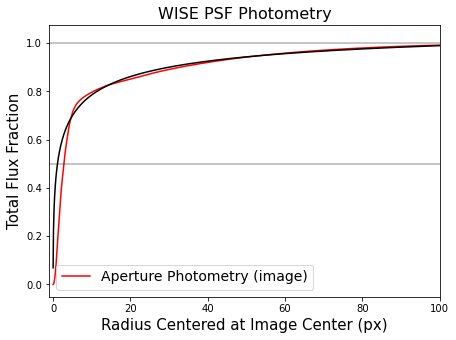

In [63]:
plt.figure(figsize=(7,5))

plt.plot(radii,enc_flux_im/np.sum(psf_output[1].data),color='red',label='Aperture Photometry (image)')
plt.plot(radii,test,color='black')

plt.axhline(1,color='black',alpha=0.3)
plt.axhline(0.5,color='black',alpha=0.3)

plt.xlabel('Radius Centered at Image Center (px)',fontsize=15)
plt.ylabel('Total Flux Fraction',fontsize=15)
plt.title('WISE PSF Photometry',fontsize=16)
plt.legend(fontsize=14)
plt.xlim(-1,100)
plt.show()

#find parameters of sersic profile that appear to 'best fit' the red line, then run galfit on psf image with those
#Re and nser fixed..? 

In [88]:
#I yield. nOtHiNg FiTs (likely because the psf is not symmetric).